In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar
import seaborn as sn
from TradingDataFrame import TradingDataFrame
from strategy import Strategy

In [2]:
import requests
start_date = datetime(2018, 2, 1)
fng_index = requests.get(f"https://api.alternative.me/fng/?limit={(datetime.today() - start_date).days}").json()

df_fng_index = pd.DataFrame(fng_index['data'])
df_fng_index = df_fng_index.rename(columns={'timestamp': 'Open Time', 'value': 'FNG Index'})
df_fng_index['Open Time'] = pd.to_datetime(df_fng_index['Open Time'], unit='s')
df_fng_index['FNG Index'] = pd.to_numeric(df_fng_index['FNG Index'])
df_fng_index = df_fng_index.set_index('Open Time').sort_index()
df_fng_index

,FNG Index,value_classification,time_until_update
Open Time,,,
2018-02-01,30,Fear,NaN
2018-02-02,15,Extreme Fear,NaN
2018-02-03,40,Fear,NaN
2018-02-04,24,Extreme Fear,NaN
2018-02-05,11,Extreme Fear,NaN
...,...,...,...
2023-03-22,62,Greed,NaN
2023-03-23,57,Greed,NaN
2023-03-24,61,Greed,NaN


In [3]:
# Binance packages

from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.exceptions import BinanceAPIException

stuffs = ''
api_key = ''
api_secret = ''

client = Client(api_key, api_secret)
prices = pd.DataFrame(client.get_all_tickers())

start_date_str = str(start_date.day) + ' ' + calendar.month_abbr[start_date.month] + ' ' + str(start_date.year)
today_date = str(datetime.today().day+1) + ' ' + calendar.month_abbr[datetime.today().month] + ' ' + str(datetime.today().year)

# Extract BTCUSDT data

klines = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1DAY, start_date_str, today_date)
klines_cols = [
    'Open Time',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Close time',
    'Quote asset volume',
    'Number of trades',
    'Taker buy base asset volume',
    'Taker buy quote asset volume',
    'Ignore']

# Setup df

df = pd.DataFrame(klines, columns=klines_cols)
df = df[['Open Time', 'Open', 'High', 'Low', 'Close']].copy()
df.drop_duplicates(inplace=True)

In [4]:
tdf = TradingDataFrame(df, time_col=df.columns[0], price_cols=df.columns[1:], time_unit='ms')

In [5]:
log_prices = tdf.log_data.copy()
log_returns = tdf.log_returns.copy()

In [6]:
df_test = log_prices.copy()

In [7]:
df_test['High next day'] = df_test['High'].shift(-1)
df_test['Low next day'] = df_test['Low'].shift(-1)
df_test = df_test.iloc[:-1].copy()

In [8]:
df_test = pd.merge(df_test, df_fng_index, left_index=True, right_index=True)
df_test

,Open,High,Low,Close,High next day,Low next day,FNG Index,value_classification,time_until_update
Open Time,,,,,,,,,
2018-02-01,9.238549,9.243388,9.077036,9.129729,9.132487,8.988573,30,Fear,NaN
2018-02-02,9.129729,9.132487,8.988573,9.090884,9.156308,9.015541,15,Extreme Fear,NaN
2018-02-03,9.090884,9.156308,9.015541,9.127063,9.145162,8.978534,40,Fear,NaN
2018-02-04,9.127063,9.145162,8.978534,9.010157,9.034057,8.798757,24,Extreme Fear,NaN
2018-02-05,9.009568,9.034057,8.798757,8.845200,8.971956,8.699683,11,Extreme Fear,NaN
...,...,...,...,...,...,...,...,...,...
2023-03-21,10.229838,10.255536,10.214792,10.243755,10.270525,10.188772,68,Greed,NaN
2023-03-22,10.243838,10.270525,10.188772,10.212881,10.266428,10.207510,62,Greed,NaN
2023-03-23,10.212881,10.266428,10.207510,10.250490,10.253274,10.203629,57,Greed,NaN


In [9]:
train_size = 0.7
train_num = round(len(df_test)*0.7)

X_train = df_test[['Close', 'High', 'Low', 'FNG Index']].iloc[:train_num].values
y_train_high = df_test[['High next day']][:train_num].values
y_train_low = df_test[['Low next day']][:train_num].values

X_test = df_test[['Close', 'High', 'Low', 'FNG Index']].iloc[train_num:].values
y_test_high = df_test[['High next day']][train_num:].values
y_test_low = df_test[['Low next day']][train_num:].values

In [10]:
from sklearn.linear_model import LinearRegression

linreg_high = LinearRegression().fit(X_train, y_train_high)
print(linreg_high.score(X_train, y_train_high), linreg_high.score(X_test, y_test_high))

linreg_low = LinearRegression().fit(X_train, y_train_low)
print(linreg_low.score(X_train, y_train_low), linreg_low.score(X_test, y_test_low))

0.9987593431450584 0.9974067285193057
0.9979618269648791 0.9954028970544451


In [11]:
klines = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_15MINUTE, start_date_str, today_date)
klines_cols = [
    'Open Time',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Close time',
    'Quote asset volume',
    'Number of trades',
    'Taker buy base asset volume',
    'Taker buy quote asset volume',
    'Ignore']

# Setup df

df_15min = pd.DataFrame(klines, columns=klines_cols)
df_15min = df_15min[['Open Time', 'Open', 'High', 'Low', 'Close']].copy()
df_15min.drop_duplicates(inplace=True)

In [12]:
klines = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1DAY, start_date_str, today_date)
klines_cols = [
    'Open Time',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Close time',
    'Quote asset volume',
    'Number of trades',
    'Taker buy base asset volume',
    'Taker buy quote asset volume',
    'Ignore']

# Setup df

df_1d = pd.DataFrame(klines, columns=klines_cols)
df_1d = df_1d[['Open Time', 'Open', 'High', 'Low', 'Close']].copy()
df_1d.drop_duplicates(inplace=True)

In [13]:
tdf_15min = TradingDataFrame(df_15min, time_col=df_15min.columns[0], price_cols=df_15min.columns[1:], time_unit='ms')
tdf_1d = TradingDataFrame(df_1d, time_col=df_1d.columns[0], price_cols=df_1d.columns[1:], time_unit='ms')

In [14]:
def ml_predict(x):
    x = [x.values]
    high = linreg_high.predict(x)[0][0]
    low = linreg_low.predict(x)[0][0]
    return high, low

In [15]:
checking = pd.merge(tdf_1d.data, df_fng_index[['FNG Index']], left_index=True, right_index=True, how='outer')
dates_missing = checking[checking.isna().any(axis=1)]
df_fng_index = pd.concat([df_fng_index, dates_missing[['FNG Index']]])
df_fng_index = df_fng_index.interpolate()
df_fng_index = df_fng_index.sort_index()

In [16]:
df_fng_index

,FNG Index,value_classification,time_until_update
Open Time,,,
2018-02-01,30.0,Fear,NaN
2018-02-02,15.0,Extreme Fear,NaN
2018-02-03,40.0,Fear,NaN
2018-02-04,24.0,Extreme Fear,NaN
2018-02-05,11.0,Extreme Fear,NaN
...,...,...,...
2023-03-22,62.0,Greed,NaN
2023-03-23,57.0,Greed,NaN
2023-03-24,61.0,Greed,NaN


In [17]:
df_criteria = tdf_15min.log_data.copy()
df_criteria['Open Time'] = df_criteria.index
df_criteria.index = df_criteria.index.strftime('%Y-%m-%d')
df_criteria.index = pd.to_datetime(df_criteria.index)
df_criteria = df_criteria[['Close', 'High', 'Low', 'Open Time']].copy()

In [18]:
df_1d_ml = tdf_1d.log_data[['Close', 'High', 'Low']].copy()
df_1d_ml = pd.merge(df_1d_ml, df_fng_index[['FNG Index']], left_index=True, right_index=True, how='left')
df_1d_ml[['Predicted High', 'Predicted Low']] = df_1d_ml.apply(ml_predict, axis=1, result_type='expand')
df_1d_ml['Predicted High_shift'] = df_1d_ml['Predicted High'].shift(1)
df_1d_ml['Predicted Low_shift'] = df_1d_ml['Predicted Low'].shift(1)
df_1d_ml = df_1d_ml[['Predicted High_shift', 'Predicted Low_shift']].copy()

In [19]:
df_cri = pd.merge(df_criteria, df_1d_ml, left_index=True, right_index=True, how='left')
df_cri = df_cri[df_cri.notna().all(axis=1)]
df_cri = df_cri.set_index('Open Time')

In [20]:
start_date = datetime(2018, 2, 2)
start_date_str = str(start_date.day) + ' ' + calendar.month_abbr[start_date.month] + ' ' + str(start_date.year)
klines = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_15MINUTE, start_date_str, today_date)
klines_cols = [
    'Open Time',
    'Open',
    'High',
    'Low',
    'Close',
    'Volume',
    'Close time',
    'Quote asset volume',
    'Number of trades',
    'Taker buy base asset volume',
    'Taker buy quote asset volume',
    'Ignore']

# Setup df

df_15min = pd.DataFrame(klines, columns=klines_cols)
df_15min = df_15min[['Open Time', 'Open', 'High', 'Low', 'Close']].copy()
df_15min.drop_duplicates(inplace=True)

In [21]:
df_15min = df_15min[['Open Time', 'Close']]

In [22]:
tdf_15min = TradingDataFrame(df_15min, time_col=df_15min.columns[0], price_cols=df_15min.columns[1:], time_unit='ms')

In [23]:
close_15min = tdf_15min.data.copy()
close_15min['Open Time'] = close_15min.index
close_15min.index = close_15min.index.strftime('%Y-%m-%d')
close_15min.index = pd.to_datetime(close_15min.index)
close_15min = close_15min[['Close', 'Open Time']].copy()

In [24]:
df_1d_ml = df_1d_ml[~df_1d_ml.index.duplicated(keep='first')]
df_1d_ml

,Predicted High_shift,Predicted Low_shift
Open Time,,
2018-02-01,NaN,NaN
2018-02-02,9.181604,9.066484
2018-02-03,9.133920,9.039538
2018-02-04,9.169138,9.079782
2018-02-05,9.063134,8.944544
...,...,...
2023-03-22,10.268509,10.214858
2023-03-23,10.247886,10.169908
2023-03-24,10.278712,10.216388


In [25]:
df_cri2 = pd.merge(close_15min, df_1d_ml, left_index=True, right_index=True, how='left')
df_cri2

,Close,Open Time,Predicted High_shift,Predicted Low_shift
Open Time,,,,
2018-02-02,9053.02,2018-02-02 00:00:00,9.181604,9.066484
2018-02-02,8949.52,2018-02-02 00:15:00,9.181604,9.066484
2018-02-02,8964.29,2018-02-02 00:30:00,9.181604,9.066484
2018-02-02,8860.03,2018-02-02 00:45:00,9.181604,9.066484
2018-02-02,8969.88,2018-02-02 01:00:00,9.181604,9.066484
...,...,...,...,...
2023-03-26,27943.64,2023-03-26 14:15:00,10.242026,10.195154
2023-03-26,27806.44,2023-03-26 14:30:00,10.242026,10.195154
2023-03-26,27795.22,2023-03-26 14:45:00,10.242026,10.195154


In [26]:
df_cri2

,Close,Open Time,Predicted High_shift,Predicted Low_shift
Open Time,,,,
2018-02-02,9053.02,2018-02-02 00:00:00,9.181604,9.066484
2018-02-02,8949.52,2018-02-02 00:15:00,9.181604,9.066484
2018-02-02,8964.29,2018-02-02 00:30:00,9.181604,9.066484
2018-02-02,8860.03,2018-02-02 00:45:00,9.181604,9.066484
2018-02-02,8969.88,2018-02-02 01:00:00,9.181604,9.066484
...,...,...,...,...
2023-03-26,27943.64,2023-03-26 14:15:00,10.242026,10.195154
2023-03-26,27806.44,2023-03-26 14:30:00,10.242026,10.195154
2023-03-26,27795.22,2023-03-26 14:45:00,10.242026,10.195154


In [27]:
tdf_15min.set_criteria_df(tdf_15min.log_data)

Strategy applied!
# of trades: 513
Sharpe ratio: -1.78


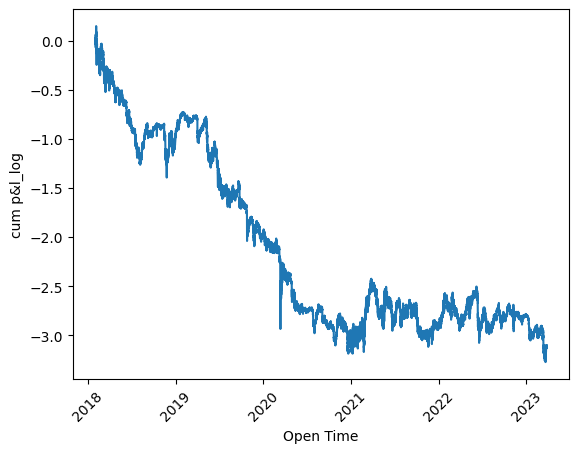

In [29]:
high_low = Strategy('btc_high_low')
high_low.set_strategy(
    long_entry = ['<', df_cri2[['Predicted Low_shift']]],
    long_exit = ['>', df_cri2[['Predicted High_shift']]],
    short_entry = ['>', df_cri2[['Predicted High_shift']]],
    short_exit = ['<', df_cri2[['Predicted Low_shift']]]
)
high_low.backtest(tdf_15min, trading_fee=0.001)